In [1]:
# This chapter talks about the bayesian method applied to analyzing
# the difference in their spreading of parameters between two groups
# of experiments. For example, for a new study method claiming to
# increase reading ability, we can test whether there is a difference
# in their claimed difference or it's just a fluke given the data.

# The difference between the last chapter is the focus on testing all
# possible mean and variance, instead of the exact mean and variance
# calculated from the data. Only when we know the distribution of all
# possible mean and variance can we say at what probability can the
# data be generated by the actual same mean and variance.

In [2]:
! test -f data/drp_scores.csv || wget -O data/drp_scores.csv https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/drp_scores.csv

In [3]:
%load_ext autoreload
# so I can change utils.py without reloading manually
%autoreload 3


import pandas as pd
import numpy as np
from utils import Pmf, make_joint, marginal, plot_contour, plot_joint
from scipy.stats import gaussian_kde, norm

df = pd.read_csv('data/drp_scores.csv', skiprows=21, delimiter='\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


In [4]:
# Let's find the mean and std value of the data for each group
groups = df.groupby('Treatment')
groups.aggregate(['mean', 'std'])

Response           
                mean        std
Treatment                      
Control    41.521739  17.148733
Treated    51.476190  11.007357

In [5]:
# This is the mean and std of the data. We can assume the true mean and std for each group is around these values. So we can make our hypothesis.
hypo_means = np.linspace(20, 80, 50)
hypo_std = np.linspace(5, 30, 50)

# initially, we assume a uniform distribution for the prior mean and std
prior_mean = Pmf(1, hypo_means)
prior_std = Pmf(1, hypo_std)

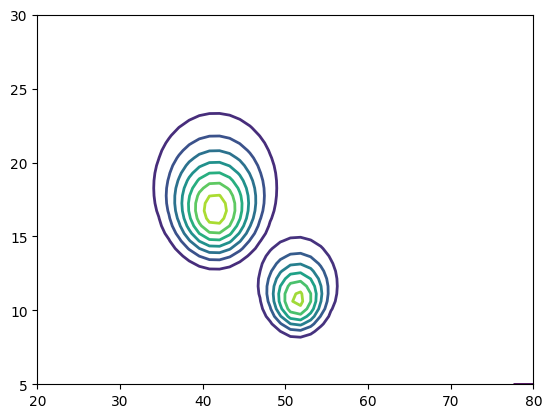

In [6]:
# Let's make a joint distribution for each hypo and means, as well as data
def update(prior_mean, prior_std, data):
    hypo_means = prior_mean.qs
    hypo_std = prior_std.qs
    M, S, D = np.meshgrid(hypo_means, hypo_std, data)
    likelihoods = norm(M, S).pdf(D).prod(axis=2)
    posterior = make_joint(prior_mean, prior_std)
    posterior *= likelihoods
    return posterior

control_posterior = update(prior_mean, prior_std, list(groups.get_group('Control')['Response']))
treated_posterior = update(prior_mean, prior_std, list(groups.get_group('Treated')['Response']))
plot_contour(control_posterior)
plot_contour(treated_posterior)

0.9775025917230056

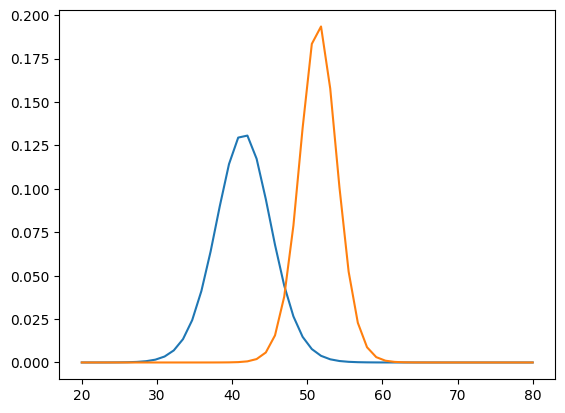

In [7]:
# Now let's tell how likely the treated group really have a higher mean.
control_mean = marginal(control_posterior, 0)
treated_mean = marginal(treated_posterior, 0)

control_mean.normalize()
treated_mean.normalize()
control_mean.plot()
treated_mean.plot()

treated_mean.prob_gt(control_mean)

<Axes: >

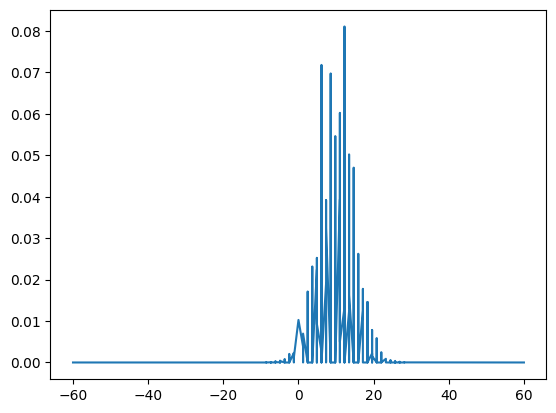

In [8]:
# just knowing that the probability of the true mean of one group is higher than the group is not enough.
# we may also want to know how much higher it is and the spreading of the difference.
# So we resort to getting the distribution of the difference of the two distribution.

diff_mean = treated_mean.sub_dist(control_mean)
diff_mean.plot()

<Axes: >

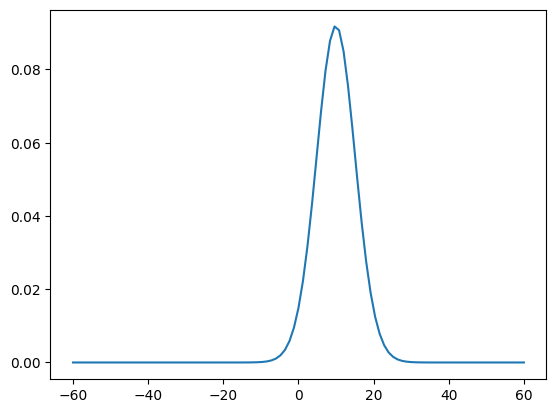

In [9]:
# the non-smoothness is because that the pair-wise difference between the two discrete pmf do not
# always cover all values in the range. and there is also floating point accuracy to take into account -
# when there is a slight off, two values originally add up (2x apparent height)
# may ends up showing two bars (1x height but twice the width)
from utils import kde_from_pmf
# To fix this, we can just calculate a gaussian kde out of it.
diff_mean_smoothed = kde_from_pmf(diff_mean)
diff_mean_smoothed.plot()

In [10]:
# there are two problems when applying this approach to a larger dataset:
#
# 1. the computation and storage of the 3d array (mean, std, data) can be huge if data is huge
# 2. since every norm(mean, std).pdf(data) is a small number less than one, if there is a lot of data
#    the product can get to values smaller than what can be represeneted by floating point.
#
# this is where we need summary statistics.

# If we are given mu (true mean), sigma (true std), n (sample size),
# we can calculate the distribution of
#
# 1. m (sample mean): normal distribution with parameters mu and sigma/sqrt(n)
# 2. s (sample std): Chi-squared distribution with parameter n-1 on t=n s^2/sigma^2
# 
# which are the likelihood of m and s we need.

# According to Basu's theorem, m and s are independent, so we can multiply the likelihoods to
# get the combined likelihood.

def get_summary(data):
    return len(data), data.mean(), data.std()

control_summary = get_summary(groups.get_group('Control')['Response'])
treated_summary = get_summary(groups.get_group('Treated')['Response'])
print(control_summary, treated_summary)

(23, 41.52173913043478, 17.148733229699484) (21, 51.476190476190474, 11.00735684721381)


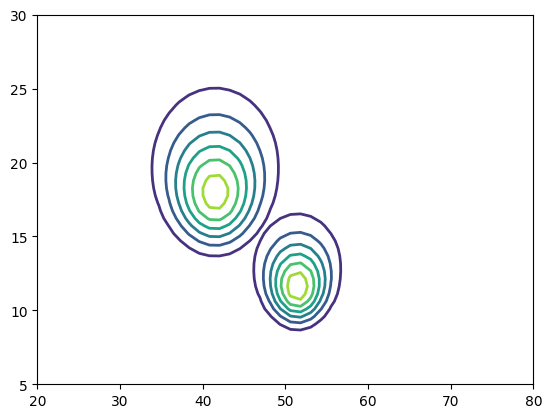

In [11]:
from scipy.stats import chi2

def update_summary(prior_mean, prior_std, summary):
    n, m, s = summary
    hypo_means = prior_mean.qs
    hypo_std = prior_std.qs
    M, S = np.meshgrid(hypo_means, hypo_std)
    
    m_likelihood = norm(M, S / np.sqrt(n)).pdf(m)
    s_likelihood = chi2(n-1).pdf(n*(s**2) / (S**2))

    likelihood = m_likelihood * s_likelihood

    posterior = make_joint(prior_mean, prior_std)
    posterior *= likelihood
    return posterior


control_posterior_summary = update_summary(prior_mean, prior_std, control_summary)
treated_posterior_summary = update_summary(prior_mean, prior_std, treated_summary)
plot_contour(control_posterior_summary)
plot_contour(treated_posterior_summary)

<Axes: >

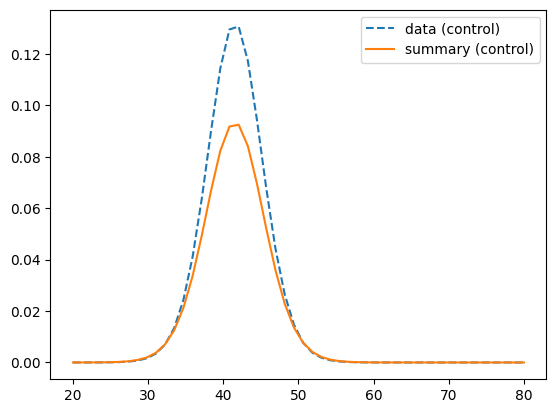

In [12]:
# the contour map shows that the distribution of the values are at the right place,
# but it has larger spreading. let's compare the marginal on mean between
# the summary version and the raw data version.
control_mean_summary = marginal(control_posterior_summary, 0)

control_mean.plot(style='--', label="data (control)", legend=True)
control_mean_summary.plot(label="summary (control)", legend=True)

In [13]:
# the book explains that the spreading is expected because we don't have the raw data.
# so we're less certain about the true distribution of the data.

0.9659445586372216

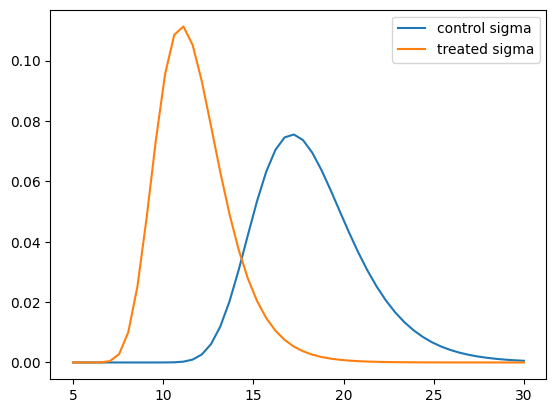

In [14]:
# Exercise 13-1: Analyze the marginal posterior distribution of sigma for the two groups.
control_sigma = marginal(control_posterior, 1)
treated_sigma = marginal(treated_posterior, 1)

control_sigma.normalize()
treated_sigma.normalize()
control_sigma.plot(label="control sigma")
treated_sigma.plot(label="treated sigma")
control_sigma.prob_gt(treated_sigma)

(9.954420839203559, array([ 1.2, 18. ]))

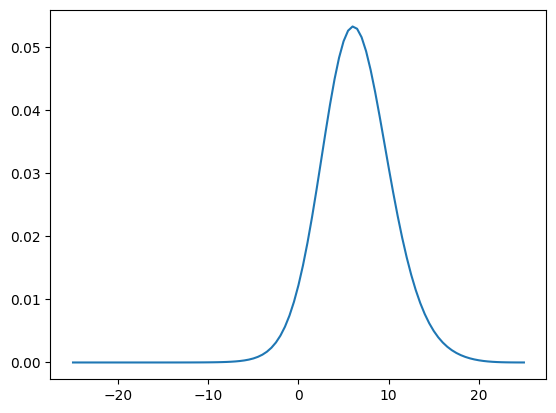

In [15]:
# what's the mean of the difference? what's the 90% credible interval?
diff_sigma = control_sigma.sub_dist(treated_sigma)
diff_sigma_smoothed = kde_from_pmf(diff_sigma)
diff_sigma_smoothed.plot()

(diff_mean_smoothed.mean(), diff_mean_smoothed.credible_interval(0.9))

In [16]:
# Exercise 13-2: Cohen's effect size between two groups (mu1, sigma1) and (mu2, sigma2) is calculated by
# d = (mu1 - mu2) / 0.5 * (sigma1 + sigma2). Use it to calcualte the effect size for the posterior distribution.

def cohen_effect_size(control_posterior, treated_posterior):
    control_mean = marginal(control_posterior, 0)
    treated_mean = marginal(treated_posterior, 0)
    control_sigma = marginal(control_posterior, 1)
    treated_sigma = marginal(treated_posterior, 1)
    
    control_mean.normalize()
    treated_mean.normalize()
    control_sigma.normalize()
    treated_sigma.normalize()

    return (control_mean.mean() - treated_mean.mean()) / (0.5 * (control_sigma.mean() + treated_sigma.mean()))

cohen_effect_size(control_posterior, treated_posterior)

-0.66476814680342

10.59900191624079

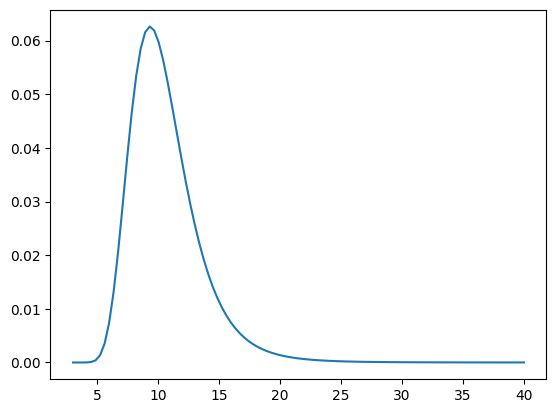

In [17]:
# Exercise 13-3: An instructor announces the results of an exam: "The average score on
# the exam is 81. Out of 25 students, 5 got more than 90, and no one failed (i.e. less than 60)".
#
# Determine the standard deviation of the scores. Assuming the scores follow a normal distribution.
# Assume the sample mean is population mean.
from scipy.stats import binom
sigma_qs = np.linspace(3, 40, 101)
sigma_prior = Pmf(1, sigma_qs)
likelihood_1 = binom.pmf(5, 25, 1 - norm(81, sigma_qs).cdf(90))
likelihood_2 = binom.pmf(0, 20, norm(81, sigma_qs).cdf(60))
sigma_posterior = sigma_prior * likelihood_1 * likelihood_2
sigma_posterior.normalize()
sigma_posterior.plot()
sigma_posterior.mean()

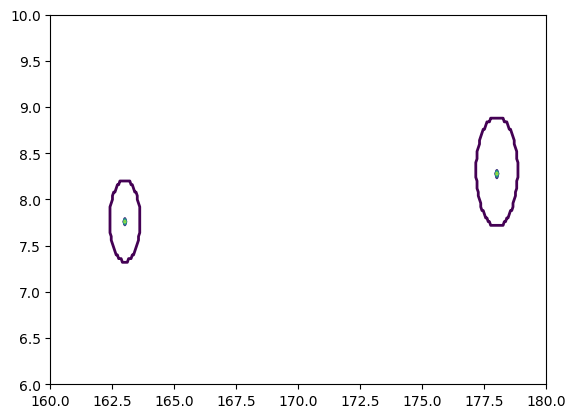

In [18]:
# Exercise 13-4: The coefficient of variation (CV) is a dimensionless measure of variability relative to
# scale, calculated by mu/sigma. Findd whether the male's height is more variable than the female's height.
# (known as Variability Hypothesis)
#
# Given summary statistics on 154,407 men and 254,722 women:
#
#   - men: m=178, s=8.27
#   - women: m=163, s=7.75
#
# Find the most likely ratio of the CVs.

def update_for_group(joint, m, s, n):
    qs_mu = joint.columns
    qs_sigma = joint.index
    M, S = np.meshgrid(qs_mu, qs_sigma)
    m_likelihood = norm(M, S / np.sqrt(n)).pdf(m)
    s_likelihood = chi2(n-1).pdf(n*(s**2) / (S**2))
    likelihood = m_likelihood * s_likelihood
    posterior = joint * likelihood
    return posterior

qs_mu = np.linspace(160, 180, 401)
qs_sigma = np.linspace(6, 10, 101)
prior_mu = Pmf(1, qs_mu)
prior_sigma = Pmf(1, qs_sigma)
prior_joint = make_joint(prior_mu, prior_sigma)
posterior_joint_male   = update_for_group(prior_joint, 178, 8.27, 154407)
posterior_joint_female = update_for_group(prior_joint, 163, 7.75, 254722)
plot_contour(posterior_joint_male)
plot_contour(posterior_joint_female)

<Axes: >

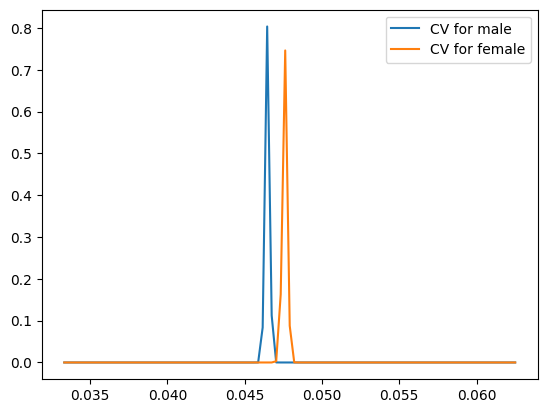

In [19]:
# The plot shows that the summary is very accurate given the large sample size. Now let's find the CV.

def cv_pmf(joint):
    mean_pmf = marginal(joint, 0)
    std_pmf = marginal(joint, 1)
    mean_pmf.normalize()
    std_pmf.normalize()
    return kde_from_pmf(std_pmf.div_dist(mean_pmf))

cv_male = cv_pmf(posterior_joint_male)
cv_female = cv_pmf(posterior_joint_female)
cv_male.plot(label="CV for male", legend=True)
cv_female.plot(label="CV for female", legend=True)

In [20]:
# So the CV for male indeed look higher than female. What's the probability?
print(cv_female.prob_gt(cv_male),)

# What's the 90% credible interval for the distribution of CV ratio?
ratio = cv_female.div_dist(cv_male)
ratio.credible_interval(0.9)

0.9999989025326116


array([1.01871658, 1.03158845])